### Python Libraries

In [1]:
import faiss
import json 
import numpy as np
import os
import PIL
import pandas as pd
import pickle
import torch
import torch.nn.functional as F

from datetime import datetime
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader,Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, models



2024-07-01 12:07:22.476738: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 12:07:23.424976: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Folder Structure

Run the following cell to ensure the project folder is set up correctly.

In [ ]:
os.makedirs('Datasets', exist_ok=True)
os.makedirs('Datasetss/images', exist_ok=True)
os.makedirs('Datasetss/cleaned_images_224', exist_ok=True)
os.makedirs('model_evaluation', exist_ok=True)
os.makedirs('model_evaluation/final_model', exist_ok=True)
os.makedirs('model_evaluation/weights', exist_ok=True)


## Dataset Management

### Importing the datasets

The dataset is stored in the file `products.csv` file and has the following columns:

- id
- product_name
- category
- product_description
- price
- location

We'll onyl need the id, category and price columns, but let's import everything.

In [2]:
dataset = pd.read_csv('Datasets/Products.csv', lineterminator='\n')

### Dataset Cleaning

Let's print out some data regarding the dataframe.

In [3]:
# Print out general information.
print(dataset.info())

# Count the number of entries in the dataset.
print(dataset.count())

# Count the number of non-null entires in the dataset.
print(dataset.dropna().count())

# Check all the price entries begin with a pound sign.
print(dataset["price"].map(lambda x: x[0]).unique())

# Check all the price entries are two point floats.
print(dataset["price"].map(lambda x: x[-3:]).unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7156 entries, 0 to 7155
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           7156 non-null   int64 
 1   id                   7156 non-null   object
 2   product_name         7156 non-null   object
 3   category             7156 non-null   object
 4   product_description  7156 non-null   object
 5   price                7156 non-null   object
 6   location             7156 non-null   object
dtypes: int64(1), object(6)
memory usage: 391.5+ KB
None
Unnamed: 0             7156
id                     7156
product_name           7156
category               7156
product_description    7156
price                  7156
location               7156
dtype: int64
Unnamed: 0             7156
id                     7156
product_name           7156
category               7156
product_description    7156
price                  7156
location           

It seems that the dataset is already clean. 

### Price column processing

Let's convert the perice column to type `float32`.

In [4]:
dataset_cleaned = dataset

# Remove all columns and pound signs from the price column.
dataset_cleaned['price'] = dataset_cleaned['price'].map(lambda x : x.replace('£', '')) #Removes the pound signs
dataset_cleaned['price'] = dataset_cleaned['price'].map(lambda x: x.replace(',', '')) #Removes commas

# Transform it to numeric type.
dataset_cleaned['price'] = pd.to_numeric(dataset_cleaned['price'])

### Category processing

We'd like to extract the root category from each entry. If we examine the category entries, we see that subcategories are differentiated by a '/'. So we can use the `string.split` method to extract the highest level category.

In [5]:
dataset_cleaned['category'] = dataset_cleaned['category'].map(lambda x: x.split(' /' )[0])

Let's list all the unique values in `dataset_cleaned['category']` to check this was done correctly.

In [6]:
dataset_cleaned['category'].unique()

array(['Home & Garden', 'Baby & Kids Stuff', 'DIY Tools & Materials',
       'Music, Films, Books & Games', 'Phones, Mobile Phones & Telecoms',
       'Clothes, Footwear & Accessories', 'Other Goods',
       'Health & Beauty', 'Sports, Leisure & Travel', 'Appliances',
       'Computers & Software', 'Office Furniture & Equipment',
       'Video Games & Consoles'], dtype=object)

### Encoding the categories

We'll create a dictionary to assign each category a numeric value, called `encoder`, and another dictionary `decoder` to do the inverse. Then we save them as pickle files.

In [7]:
# Create a list of all the unique categories.
list_of_categories = list(dataset_cleaned['category'].unique())

encoder = {x: list_of_categories.index(x) for x in list_of_categories}
decoder = {list_of_categories.index(x):x for x in list_of_categories}

#Save these to pickle files:
with open("encoder_pickle", 'wb') as encody:
    pickle.dump(encoder, encody)

with open("app/Pickle_Files/encoder_pickle", 'wb') as encody:
    pickle.dump(encoder, encody)

with open("decoder_pickle", 'wb') as decody:
    pickle.dump(decoder, decody)

with open("app/Pickle_Files/decoder_pickle", 'wb') as decody:
    pickle.dump(decoder, decody)

Finally, we add a new column called `'root_category'` which contains the numeric value associated with the category.

In [8]:
dataset_cleaned['root_category'] = dataset_cleaned['category']
dataset_cleaned['root_category_index'] = dataset_cleaned['category'].map(lambda x:encoder[x])

### Merging with Images id

The image associated with each product is specified in the file `images.csv`. Within it, there are two columns:

- id - Contains the file name of the image associated with the item
- product_id - The id, in the sense of `products.csv` of the product associated with the image.

We'd like to create a new table with the following:

- The product id of each product
- The image file name associated with the image
- The numeric value of the category associated with the product

In [9]:
# Import the data from `Images.csv` to a pandas dataframe.
images_dataset = pd.read_csv('Datasets/Images.csv')

# Create new column in both `images_dataset` and `dataset_cleaned` to merge the dataframes on.
dataset_cleaned["merge_column"] = dataset_cleaned['id']
images_dataset['merge_column'] = images_dataset['product_id']

# Double check the dtypes of the dataframe
dataset_cleaned.dtypes, images_dataset.dtypes

(Unnamed: 0               int64
 id                      object
 product_name            object
 category                object
 product_description     object
 price                  float64
 location                object
 root_category           object
 root_category_index      int64
 merge_column            object
 dtype: object,
 Unnamed: 0       int64
 id              object
 product_id      object
 merge_column    object
 dtype: object)

All seems to be good, so we can go ahead and merge the dataframes.

In [10]:
merged_df = images_dataset.merge(dataset_cleaned, on='merge_column')

Of course, we only need some of the columns of `merged_df`.

In [11]:
# Grab only the columns we need from `merged_df`.
merged_df = merged_df[["id_x", "product_id", "root_category", "root_category_index"]]

# Rename the column `id_x` to just `id`.
merged_df = merged_df.rename(columns={'id_x':'id'})

# Drop the product_id column, since we only need to associated images to categories.
merged_df = merged_df.drop(columns=['product_id'])

# Double check the dtypes.
merged_df.dtypes

id                     object
root_category          object
root_category_index     int64
dtype: object

Finally we'll put everything in `merged_df` onto a `.csv` file called `training_data.csv`.

In [12]:
merged_df.to_csv('Datasets/training_data.csv', index=False)

## Image Processing

### Resizing and cropping images

The image dataset contains images of varing aspect ratios and sizes. We'd like to make them a uniform size which is small enough so that training takes a reasonable amount of time. Let's define some functions to do just that.

In [13]:
# Takes in an image and an integer. Transforms the image to a square of size `final_size`.
def resize_image(final_size:int, im:PIL.Image):

    # Current image size
    size = im.size

    # Ratio to transform the image by
    ratio = float(final_size) / max(size)
    new_image_size = tuple([int(x*ratio) for x in size])
    im = im.resize(new_image_size)
    new_im = Image.new("RGB", (final_size, final_size))
    new_im.paste(im, ((final_size-new_image_size[0])//2, (final_size-new_image_size[1])//2))
    return new_im

# Resizes all the images in `path_to_extract` to the size `image_size` and places them in `path_to_save`
def clean_images(path_to_extract:str = "Datasets/images/", path_to_save:str = "Datasets/cleaned_images/", image_size:int = 64):
    dirs = os.listdir(path_to_extract)
    final_size = image_size
    for n, item in enumerate(dirs, 1):
        im = Image.open(path_to_extract + item)
        new_im = resize_image(final_size, im)
        new_im.save(path_to_save + item)


In [14]:
# Uncomment to run the image clean function
# clean_images(path_to_save="Datasets/cleaned_images_224/")

### Creating an image dataset

We'll create a Torch dataset to load the images. It will be a class inheriting from the `torch.nn.Dataset` module.

In [15]:
class ImageDataset(Dataset):
    def __init__(self, df_of_keys:pd.DataFrame, folder_of_images:str) -> None:
        super().__init__()

        # Set the labels to be the column 'root_cotegory_index' of df_of_keys
        self.labels = df_of_keys['root_category_index']

        # Assings image_paths to the file name from the column 'id' of df_of_keys and maps it to it's path relative to the project root folder
        self.image_paths = df_of_keys['id'].map(lambda x : folder_of_images + x + '.jpg')

        # Turns the image to a Torch tensor.
        self.image_transformer = transforms.Compose([
            transforms.PILToTensor(),
        ])
    
    def __getitem__(self, index):
        
        # Opens the image at index with using PIL.Image
        with Image.open(self.image_paths[index]) as img:

            # Sets the feature to be a tensor obtained by applying PILToTensor to the relevant image
            X = self.image_transformer(img)
        
        # y is the label from self.labels
        y = self.labels[index]

        #print(X.shape, y.shape)
        return X, y
    
    def __len__(self):
        return len(self.labels)



Let's do a quick sanity check to see how the dataset looks like.

In [16]:
my_dataset = ImageDataset(merged_df, "Datasets/cleaned_images_224/")

# A quick sanity check of the dataset:
my_dataset[1][0], my_dataset[1][1].shape, len(my_dataset)

(tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
 (),
 12604)

### Splitting the dataset

Since we will only be tuning hyper-parameters and not choosing between different models, we won't need a test dataset. So let's split the dataset into train and validation splits.

In [49]:
# Split merged_df to a train_df and validation_df
train_df, validation_df = train_test_split(merged_df, train_size=10000, test_size= len(merged_df) - 10000)

# Reset the indicies
train_df.reset_index(inplace=True)
validation_df.reset_index(inplace=True)

# Create instances of the ImageDataset class
train_dataset = ImageDataset(train_df, "Datasets/cleaned_images_224/")
validation_dataset = ImageDataset(validation_df, "Datasets/cleaned_images_224/")

# Allow random flips and rotations when loading an image in the train dataset
train_dataset.image_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.PILToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Pass both to dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_dataset, batch_size=128, shuffle=True, drop_last=True)


Again let's to a quick sanity check to see we are loading the correct images.

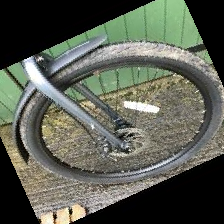

In [53]:
pillow_to_image = transforms.ToPILImage()

pillow_to_image(train_dataset[712][0].squeeze(0))

## Creating the model

Let's do some setup regarding Pytorch and the pretrained model, resnet50.

In [19]:
# Sets the device for PyTorch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Loads the resnet50 model
resnet50 = models.resnet50(weights='IMAGENET1K_V1')

# Don't know what this does
resnet50.eval().to(device)

print('Model succesfully loaded!')

Model succesfully loaded!


### Examining the model

The following is a useful function to look at the layers within a model and thier grad attributes.

In [20]:
def show_model_layers(model):
    for name, module in model.named_parameters():
        if module.requires_grad:
            print('Grad!', name, module.requires_grad)
        else:
            print(name, module.requires_grad)

In [21]:
show_model_layers(resnet50)

Grad! conv1.weight True
Grad! bn1.weight True
Grad! bn1.bias True
Grad! layer1.0.conv1.weight True
Grad! layer1.0.bn1.weight True
Grad! layer1.0.bn1.bias True
Grad! layer1.0.conv2.weight True
Grad! layer1.0.bn2.weight True
Grad! layer1.0.bn2.bias True
Grad! layer1.0.conv3.weight True
Grad! layer1.0.bn3.weight True
Grad! layer1.0.bn3.bias True
Grad! layer1.0.downsample.0.weight True
Grad! layer1.0.downsample.1.weight True
Grad! layer1.0.downsample.1.bias True
Grad! layer1.1.conv1.weight True
Grad! layer1.1.bn1.weight True
Grad! layer1.1.bn1.bias True
Grad! layer1.1.conv2.weight True
Grad! layer1.1.bn2.weight True
Grad! layer1.1.bn2.bias True
Grad! layer1.1.conv3.weight True
Grad! layer1.1.bn3.weight True
Grad! layer1.1.bn3.bias True
Grad! layer1.2.conv1.weight True
Grad! layer1.2.bn1.weight True
Grad! layer1.2.bn1.bias True
Grad! layer1.2.conv2.weight True
Grad! layer1.2.bn2.weight True
Grad! layer1.2.bn2.bias True
Grad! layer1.2.conv3.weight True
Grad! layer1.2.bn3.weight True
Grad! la

We see that the final layer of resnet50, `fc` takes in 2048 features and outputs 1000 features. The number of labels we need to classify, i.e. the number of distinct values in `merged_df['root_categories']` is 13.

The approach we'll take is to add a few extra layers to the end of resnet50 eventually reducing the number of outputs to 13.

### Defining the Model

Let's define a class for our model.


In [56]:
class ImageClassifier(torch.nn.Module):
    def __init__(self, num_labels:int) -> None:
        """
        Takes in one argument, num_labels which will the dimension of the output of the final layer.
        """
        super().__init__()
        # Load resnet50 into the object.
        self.resnet50 = models.resnet50(weights='IMAGENET1K_V1')
        
        # Freeze all the layers, by setting 'requires_grad = False'.
        for param in self.resnet50.parameters():
            param.requires_grad = False

        # Unfreeze the final layer of renset50.

        for param in self.resnet50.fc.parameters():
            param.requires_grad = True
        
        # Adjoin some extra layers to the end of the model
        
        self.layers = torch.nn.Sequential(
            self.resnet50,
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 500),
            torch.nn.Dropout(),
            torch.nn.ReLU(),
            torch.nn.Linear(500, num_labels),
            torch.nn.Softmax(dim=1),
        )

    def forward(self, X):
        """
        Standard forward method.
        """
        X = X.float()
        X = self.layers(X)
        return X
    
    def forward_no_grad(self, X):
        """
        Define a forward method which does not use grad, to speed up computaion when not training the model.
        """
        with torch.no_grad():
            X = X.float()
            X = self.layers(X)
            return X

Now that the class is set up, we can create an instance of the class.

In [57]:
# Instantiate the class with 13 outputs
model = ImageClassifier(13)

# Load the model to the device
model.to(device)

# Check the layers of newly defined model.
show_model_layers(model)

resnet50.conv1.weight False
resnet50.bn1.weight False
resnet50.bn1.bias False
resnet50.layer1.0.conv1.weight False
resnet50.layer1.0.bn1.weight False
resnet50.layer1.0.bn1.bias False
resnet50.layer1.0.conv2.weight False
resnet50.layer1.0.bn2.weight False
resnet50.layer1.0.bn2.bias False
resnet50.layer1.0.conv3.weight False
resnet50.layer1.0.bn3.weight False
resnet50.layer1.0.bn3.bias False
resnet50.layer1.0.downsample.0.weight False
resnet50.layer1.0.downsample.1.weight False
resnet50.layer1.0.downsample.1.bias False
resnet50.layer1.1.conv1.weight False
resnet50.layer1.1.bn1.weight False
resnet50.layer1.1.bn1.bias False
resnet50.layer1.1.conv2.weight False
resnet50.layer1.1.bn2.weight False
resnet50.layer1.1.bn2.bias False
resnet50.layer1.1.conv3.weight False
resnet50.layer1.1.bn3.weight False
resnet50.layer1.1.bn3.bias False
resnet50.layer1.2.conv1.weight False
resnet50.layer1.2.bn1.weight False
resnet50.layer1.2.bn1.bias False
resnet50.layer1.2.conv2.weight False
resnet50.layer1.2.bn

Let's check that the model behaves as expcted:

In [58]:
feature, label = train_dataset[0]
predition = model(feature.cuda().unsqueeze(0))

predition, predition.shape

(tensor([[0.1086, 0.0576, 0.0593, 0.0694, 0.0663, 0.0541, 0.0987, 0.0598, 0.0862,
          0.0960, 0.0817, 0.0793, 0.0830]], device='cuda:0',
        grad_fn=<SoftmaxBackward0>),
 torch.Size([1, 13]))

We see that the output has dimension 13, so everything seems to be working correctly.

### Training loop

The model will be trained using stochastic gradient descent. The training loop is the following:

In [59]:
# The training loop. Takes in a model, the training and validation data loaders, the number of epochs and the initial learning rate
def train(model, train_loader, validation_loader, epochs = 10, learning_rate = 1):

    torch.cuda.empty_cache()

    # Set the optimiser to be an instance of the stochastic gradient descent class
    # Only want the parameters in fc to be updated
    optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Define a learning rate scheduler as an instance of the ReduceLROnPlateau class
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', patience=50, cooldown=7, eps=1e-20)

    # Writer will be used to track model performance with TensorBoard
    writer = SummaryWriter()

    # Keep track of the number of batches to plot model performace against
    batch_index = 0
    
    # Prints an validation score
    print(f"Initial validation accuracy score{accuracy_score_from_valiadation(model, validation_loader)}")

    #Create a dictionary to store the best model parameters
    best_model_parameters = {'Epoch':-1, 'Accuracy':0, 'Parameters':model.state_dict()}

    # Loop over the number of epochs
    for epoch in range(epochs):

        # Within each epoch, we pass through the entire training data in batches indexed by batch
        for batch in train_loader:
            # Loads features and labels into device for performance improvements
            features, labels = batch

            features = features.to(device)
            labels = labels.to(device)

            # Calculate the loss via cross_entropy
            loss = F.cross_entropy(model(features), labels)

            # Create the grad attributes
            loss.backward() 

            # Print the performance
            print(f"Epoch: {epoch}, batch index: {batch_index}, learning rate: {scheduler.get_last_lr()}, loss:{loss.item()}")

            # Perform one step of stochastic gradient descent
            optimiser.step()

            # Zero the gradients (Apparently set_to_none=True imporves performace)
            optimiser.zero_grad(set_to_none=True)

            # Feed the loss amount into the learning rate scheduler to decide the next learning rate
            scheduler.step(loss.item())

            # Write the performance to the TensorBoard plot
            writer.add_scalar('loss', loss.item(), batch_index)

            # Increment the batch index
            batch_index += 1
        
        # Print the validation loss
        print('Calculating validation accuracy')
        accuracy = accuracy_score_from_valiadation(model, validation_loader)
        print(f"Epoch {epoch}, validation accuracy score{accuracy}")

        # Check if the model has the best perfomrance and save the parameters to 'best_model.pt'
        if accuracy > best_model_parameters['Accuracy']:
            best_model_parameters['Epoch'] = epoch
            best_model_parameters['Accuracy'] = loss.item()
            best_model_parameters['Parameters'] = model.state_dict()
            torch.save(model.state_dict(), 'model_evaluation/weights/best_model.pt')

        if epoch % 5 == 0:
            print("Saving model parameters!")
            # Create an instance of the datetime class
            dt = datetime.now()
            date_stamp = str(dt).replace(':', '_').replace('.', '_').replace(' ', '_')

            # Save the model parameters to the folder 'model_evaluation/weights', along with the time and epoch they were generated
            torch.save(model.state_dict(), f'model_evaluation/weights/model_{date_stamp}_epoch_{epoch}_accuracy_{accuracy}.pt') # Is there a better way to do this?
    
    print('Loading best model')
    
    #Update model parameters with the best model parameters:
    model.load_state_dict(best_model_parameters['Parameters'])
    print(f'The best model has validation accuracy {accuracy_score_from_valiadation(model, validation_loader)}')

def accuracy_score_from_valiadation(model, validation_loader):
    """
    Calculates the accuracy using the WHOLE of the validation dataset.
    """

    # Initialise an empty array containing the accuracy of each batch from the validation loader.
    list_of_scores = []

    # Iterates over all batches in the validation loader
    for batch in validation_loader:
        features, labels = batch

        features = features.to(device)
        labels = labels.to(device)

        predictions = torch.tensor([torch.argmax(prediction) for prediction in model.forward_no_grad(features)]).to(device)
        num_correct =  torch.sum(predictions == labels)

        list_of_scores.append(torch.div(num_correct, len(labels)).item())
    
    return sum(list_of_scores) / len(list_of_scores)



In [ ]:
# Train the model, uncomment to train
# train(model, train_loader, validation_loader, epochs=40, learning_rate=1)

We should now have a slightly trained model!

# Testing the image processing script

In [64]:
from image_processor import process_image_as_pil

with Image.open("Datasets/images/ffff23f1-59fc-47bd-b0cd-186933803287.jpg") as image:
    image_tensor = process_image_as_pil(image).to(device)

model(image_tensor)

tensor([[0.0422, 0.0480, 0.0647, 0.0291, 0.0556, 0.0487, 0.0480, 0.1224, 0.0686,
         0.1006, 0.0367, 0.2773, 0.0582]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

### Feature extraction model

The feature extraction model should take in an image and return a vector with 1000 entries loosely corresponding to the predicted image category and image characteristics. We can achieve this by taking the category classification model and removing the extra layers added on top of resnet50.

In [68]:
# Create an instance of the ImageClassifier classs with the same architecture as the previously trained model
feature_extraction_model = ImageClassifier(13)

feature_extraction_model.to(device)

# Load the same parameters from that model to this one
feature_extraction_model.load_state_dict(model.state_dict())

# Cut of the extra layers while ensuring the architecture naming scheme stays the same
feature_extraction_model.layers = torch.nn.Sequential(
    *list(feature_extraction_model.layers.children())[:-6]
)

# Print the layers as a sanity check
show_model_layers(feature_extraction_model)

# Save the feature extraction model paramters
torch.save(feature_extraction_model.state_dict(), 'model_evaluation/final_model/image_model.pt')
torch.save(feature_extraction_model.state_dict(), 'app/Model_Parameters/image_model.pt')


resnet50.conv1.weight False
resnet50.bn1.weight False
resnet50.bn1.bias False
resnet50.layer1.0.conv1.weight False
resnet50.layer1.0.bn1.weight False
resnet50.layer1.0.bn1.bias False
resnet50.layer1.0.conv2.weight False
resnet50.layer1.0.bn2.weight False
resnet50.layer1.0.bn2.bias False
resnet50.layer1.0.conv3.weight False
resnet50.layer1.0.bn3.weight False
resnet50.layer1.0.bn3.bias False
resnet50.layer1.0.downsample.0.weight False
resnet50.layer1.0.downsample.1.weight False
resnet50.layer1.0.downsample.1.bias False
resnet50.layer1.1.conv1.weight False
resnet50.layer1.1.bn1.weight False
resnet50.layer1.1.bn1.bias False
resnet50.layer1.1.conv2.weight False
resnet50.layer1.1.bn2.weight False
resnet50.layer1.1.bn2.bias False
resnet50.layer1.1.conv3.weight False
resnet50.layer1.1.bn3.weight False
resnet50.layer1.1.bn3.bias False
resnet50.layer1.2.conv1.weight False
resnet50.layer1.2.bn1.weight False
resnet50.layer1.2.bn1.bias False
resnet50.layer1.2.conv2.weight False
resnet50.layer1.2.bn

### Setting up the FAISS index search

We need to set up a matrix containing the image embeddings for all the images in out dataset. First let's cerate a dictionary containg pairs of the image id and feature extraction model embeddings, and push it onto a json file.

In [69]:
def feature_extraction(folder_of_images:str, df_of_keys):
    """
    Creates a dictionary of all the image embeddings of from the feature extraction model from images in folder_of_images. Stored as key value pairs with keys as 'id' from 'df_of_keys' and values of image embeddings.
    """

    # Set up the iamge transformer.
    transformer =  transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.PILToTensor(),
    ])
    # Initialise an empty disctionary
    dict_of_features = {}

    # List containing all the image paths
    list_of_image_paths = df_of_keys['id'].map(lambda x : folder_of_images + x + '.jpg')

    # Iterate through all images to add thier key value pair of id and image embeddings to 'dict_of_features'.
    for index in range(0, len(merged_df)):
        image_path = list_of_image_paths[index]
        with Image.open(image_path) as img:
            features = transformer(img).unsqueeze(0)
        features = features.to(device)
        image_embedding = feature_extraction_model(features)
        image_embedding = image_embedding.squeeze(0)
        image_embedding = image_embedding.tolist()
        dict_of_features[df_of_keys['id'][index]] = image_embedding

    # Save these to project folder.
    with open('image_embeddings.json', '+w') as file:
        json.dump(dict_of_features, file)

        

In [70]:
# Uncomment to run
feature_extraction('Datasets/cleaned_images_224/', merged_df)

Let's load that json file and stack all the image embeddings into a numpy array.

In [71]:
# Load the key value pairs of the image file names and image embeddings.
with open('image_embeddings.json', 'r') as file:
    new_dict = json.load(file)

# Unsqueeze each image embedding.
for key, value in new_dict.items():
    new_dict[key] = [value]

# Create a dataframe from the loaded json
vectors_df = pd.DataFrame.from_dict(new_dict, orient='index', columns=['image embedding'])

# Stack all the image embeddings into a large numpy array.
vectors = np.vstack(vectors_df['image embedding']).astype(np.float32)

# Double check the shape.
vectors.shape


(12604, 1000)

Let's add `vectors` to the faiss index search.

In [72]:
index = faiss.IndexFlatL2(1000)
index.add(vectors)

Check that the seach works as expected:

In [73]:
D, I = index.search(np.expand_dims(vectors[100], 0), 3)
print(I, I.shape)
print(D, D.shape)


[[ 100 6892 6877]] (1, 3)
[[0.       5.924145 5.924145]] (1, 3)


Finally let's save the index seach to a pickle file.

In [74]:
with open("app/faiss_pickle", 'wb') as pickly:
    pickle.dump(index, pickly)